In [80]:
import random
import scipy
import sklearn
import numpy as np
import math
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds

In [81]:
Data_frame_articles = pd.read_csv('articles_shared.csv')
Data_frame_articles = Data_frame_articles[Data_frame_articles['event-Type']
                                          == 'SHARED CONTENT']
Data_frame_articles.head(5)


,timestamp,event-Type,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1458183888,SHARED CONTENT,-4110354420626824665,4340306664483623681,8840341205206233828,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1458184146,SHARED CONTENT,-6282285110016212248,4340306664483623681,8840341205206233828,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1458184464,SHARED CONTENT,-6151852268066518688,3881636886616104548,-1456532840883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1458184486,SHARED CONTENT,2448026884306402386,4340306664483623681,8840341205206233828,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,1458184522,SHARED CONTENT,-2826566343806132236,4340306664483623681,8840341205206233828,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


In [82]:
data_frame_interactions = pd.read_csv('interactions_users.csv')
data_frame_interactions.head(10)


,timestamp,event-Type,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3488818488620038868,-8845288681288428018,1264186660338858068,NaN,NaN,NaN
1,1465412560,VIEW,8880620688208848681,-1032018228384686485,3621636643586568081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416180,VIEW,310515486418366885,-1130262284246883140,2631864456530402468,NaN,NaN,NaN
3,1465413885,FOLLOW,310515486418366885,344280848526866603,-3166636563880064150,NaN,NaN,NaN
4,1465412280,VIEW,-6820640624231356630,-445336111682615325,5611481168424124614,NaN,NaN,NaN
5,1465413642,VIEW,310515486418366885,-8663388616620485024,1385688368402380382,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,MG,BR
6,1465415850,VIEW,-8864063363662512525,3608184402283568455,1143206166886864524,NaN,NaN,NaN
7,1465415066,VIEW,-1482813151830215884,4254153380638583260,8643228464606506141,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
8,1465413662,VIEW,310515486418366885,344280848526866603,-3166636563880064150,NaN,NaN,NaN
9,1465413661,VIEW,3064360286160038610,3608184402283568455,1143206166886864524,NaN,NaN,NaN


In [83]:
eventTypeStrength = {
    'COMMENT CREATED': 4.0,
    'LIKE': 2.0,
    'FOLLOW': 3.0,
    'VIEW': 1.0,
    'BOOKMARK': 2.5,
}

data_frame_interactions['event_Strength'] = data_frame_interactions['event-Type'].apply(
    lambda x: eventTypeStrength[x])


In [84]:
interactions_users_count_dataFrame = data_frame_interactions.groupby(
    ['personId', 'contentId']).size().groupby('personId').size()
print('users: %d' % len(interactions_users_count_dataFrame))
users_with_enough_data_frame_interactions = interactions_users_count_dataFrame[interactions_users_count_dataFrame >= 5].reset_index()[
    ['personId']]
print('users at least with  5-interactions: %d' %
      len(users_with_enough_data_frame_interactions))


users: 1895
users at least with  5-interactions: 1140


In [85]:
print('of_interactions: %d' % len(data_frame_interactions))
interactions_from_selected_users_dataFrame = data_frame_interactions.merge(users_with_enough_data_frame_interactions,
                                                                           how='right',
                                                                           left_on='personId',
                                                                           right_on='personId')
print('of_interactions users with least 5 interactions: %d' %
      len(interactions_from_selected_users_dataFrame))


of_interactions: 72312
of_interactions users with least 5 interactions: 69868


In [86]:
def smooth_preference_user(x):
    return math.log(1+x, 2)

full_dataFrame_interactions = interactions_from_selected_users_dataFrame \
    .groupby(['personId', 'contentId'])['event_Strength'].sum() \
    .apply(smooth_preference_user).reset_index()
print('of_unique_user-item_interactions: %d' %
      len(full_dataFrame_interactions))
full_dataFrame_interactions.head(10)


of_unique_user-item_interactions: 39106


,personId,contentId,event_Strength
0,-8884220665455683336,-6883268686012368684,1.000000
1,-8884220665455683336,-5150441845583002812,1.000000
2,-8884220665455683336,-4663604365661208816,2.459432
3,-8884220665455683336,-4280604324633068853,1.000000
4,-8884220665455683336,-4158286466631283435,1.000000
5,-8884220665455683336,-4102286002628306038,1.000000
6,-8884220665455683336,-3686865338281665265,1.000000
7,-8884220665455683336,-3386288624563211014,1.000000
8,-8884220665455683336,-1630228586164086350,1.000000
9,-8884220665455683336,-860651600882244121,1.000000


In [87]:
train_dataFrame_interactions, test_dataFrame_interactions = train_test_split(full_dataFrame_interactions,
                                                                             stratify=full_dataFrame_interactions[
                                                                                 'personId'],
                                                                             test_size=0.20,
                                                                             random_state=42)

print('interactions_on_Train_set: %d' % len(train_dataFrame_interactions))
print('interactions_on_testing_set: %d' % len(test_dataFrame_interactions))


interactions_on_Train_set: 31284
interactions_on_testing_set: 7822


In [88]:
full_indexed_dataFrame_interactions = full_dataFrame_interactions.set_index(
    'personId')
train_indexed_dataFrame_interactions = train_dataFrame_interactions.set_index(
    'personId')
test_indexed_dataFrame_interactions = test_dataFrame_interactions.set_index(
    'personId')


In [89]:
def get_items_interacted(id_of_person, data_frame_interactions):
    items_interacted = data_frame_interactions.loc[id_of_person]['contentId']
    return set(items_interacted if type(items_interacted) == pd.Series else [items_interacted])


In [90]:
NON_interacted_items_SAMPLE_RANDOM_EVAL = 100


class ModelEvaluator:

    def getting_not_interacted_items_sample(self, id_of_person, size_of_sample, S_E_E_D=42):
        items_interacted = get_items_interacted(
            id_of_person, full_indexed_dataFrame_interactions)
        all_items = set(Data_frame_articles['contentId'])
        non_items_interacted = all_items - items_interacted

        random.seed(S_E_E_D)
        non_interacted_items_sample = random.sample(
            non_items_interacted, size_of_sample)
        return set(non_interacted_items_sample)

    def hit_top_verify_n(self, id_of_item, recommended_items, top_n):
        try:
            n = next(i for i, c in enumerate(
                recommended_items) if c == id_of_item)
        except:
            n = -1
        hit = int(n in range(0, top_n))
        return hit, n

    def evaluating_model_user(self, model, id_of_person):
        testing_set_for_interacted_values = test_indexed_dataFrame_interactions.loc[id_of_person]
        if type(testing_set_for_interacted_values['contentId']) == pd.Series:
            testing_set_person_interacted_items = set(
                testing_set_for_interacted_values['contentId'])
        else:
            testing_set_person_interacted_items = set(
                [int(testing_set_for_interacted_values['contentId'])])
        items_interacted_count_testset = len(testing_set_person_interacted_items)

        person_recs_dataFrame = model.items_recommend(id_of_person,
                                                      ignoring_items=get_items_interacted(id_of_person,
                                                                                           train_indexed_dataFrame_interactions),
                                                      top_n=10000000000)

        hits_on_5_count = 0
        hits_on_10_count = 0

        for id_of_item in testing_set_person_interacted_items:
            non_interacted_items_sample = self.getting_not_interacted_items_sample(id_of_person,
                                                                                   size_of_sample=NON_interacted_items_SAMPLE_RANDOM_EVAL,
                                                                                   S_E_E_D=id_of_item % (2**32))

            filter_items_to_recs = non_interacted_items_sample.union(
                set([id_of_item]))

            valid_recs_dataFrame = person_recs_dataFrame[person_recs_dataFrame['contentId'].isin(
                filter_items_to_recs)]
            valid_recs = valid_recs_dataFrame['contentId'].values
            hit_on_5, index_at_5= self.hit_top_verify_n(
                id_of_item, valid_recs, 5)
            hits_on_5_count += hit_on_5
            hit_on_10,index_at_10 = self.hit_top_verify_n(
                id_of_item, valid_recs, 10)
            hits_on_10_count += hit_on_10

        recall_on_5 = hits_on_5_count / float(items_interacted_count_testset)
        recall_on_10 = hits_on_10_count / float(items_interacted_count_testset)

        metric_of_person = {'hits@5_count': hits_on_5_count,
                            'hits@10_count': hits_on_10_count,
                            'interacted_count': items_interacted_count_testset,
                            'recall@5': recall_on_5,
                            'recall@10': recall_on_10}
        return metric_of_person

    def evaluating_model(self, model):
        metrics_of_people = []
        for id_x, id_of_person in enumerate(list(test_indexed_dataFrame_interactions.index.unique().values)):
            metric_of_person = self.evaluating_model_user(model, id_of_person)
            metric_of_person['_id_of_person'] = id_of_person
            metrics_of_people.append(metric_of_person)
        print('%dusers_processed' % id_x)

        results_detailed_dataFrame = pd.DataFrame(metrics_of_people) \
            .sort_values('interacted_count', ascending=False)

        global_recall_on_5 = results_detailed_dataFrame['hits@5_count'].sum() / float(
            results_detailed_dataFrame['interacted_count'].sum())
        global_recall_on_10 = results_detailed_dataFrame['hits@10_count'].sum(
        ) / float(results_detailed_dataFrame['interacted_count'].sum())

        metrics_global = {'modelName': model.get_NAME_OF_MODEL(),
                          'recall@5': global_recall_on_5,
                          'recall@10': global_recall_on_10}
        return metrics_global, results_detailed_dataFrame


model_evaluator = ModelEvaluator()


Popularity model


In [91]:
popularity_of_item_dataFrame = full_dataFrame_interactions.groupby(
    'contentId')['event_Strength'].sum().sort_values(ascending=False).reset_index()
popularity_of_item_dataFrame.head(10)


,contentId,event_Strength
0,-4028604625606465084,307.733799
1,-6683662548652081658,233.762157
2,-133138342386538858,228.024567
3,-8208801366848626843,197.107608
4,-6843046688858121624,193.825208
5,8224860111183156880,189.044680
6,-2358656618610361882,183.110951
7,2581138406638454418,180.282876
8,6506066865564686362,179.094002
9,1468580151036142803,170.548969


In [92]:
class PopularityRecommender:

    NAME_OF_MODEL = 'Popularity'

    def __init__(self, dataFrame_popularity, dataFrame_items=None):
        self.dataFrame_popularity = dataFrame_popularity
        self.dataFrame_items = dataFrame_items

    def get_NAME_OF_MODEL(self):
        return self.NAME_OF_MODEL

    def items_recommend(self, ID_of_user, ignoring_items=[], top_n=10, verbose=False):
        dataFrame_recommendations = self.dataFrame_popularity[~self.dataFrame_popularity['contentId'].isin(ignoring_items)] \
            .sort_values('event_Strength', ascending=False) \
            .head(top_n)

        if verbose:
            if self.dataFrame_items is None:
                raise Exception(
                    '"dataFrame_items"-is_required_verbose_mode')

            dataFrame_recommendations = dataFrame_recommendations.merge(self.dataFrame_items, how='left',
                                                                        left_on='contentId',
                                                                        right_on='contentId')[['event_Strength', 'contentId', 'title', 'url', 'lang']]

        return dataFrame_recommendations


model_for_popularity = PopularityRecommender(
    popularity_of_item_dataFrame, Data_frame_articles)


In [93]:
pop_metrics_global, pop_results_detailed_dataFrame = model_evaluator.evaluating_model(model_for_popularity)
print('\n Metrics Global:\n%s' % pop_metrics_global)
pop_results_detailed_dataFrame.head(10)


C:\Users\Dell\AppData\Local\Temp\ipykernel_8040\3275908084.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(


1139users_processed
\ Metrics nGlobal:
{'modelName': 'Popularity', 'recall@5': 0.25031961135259523, 'recall@10': 0.3786755305548453}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_id_of_person
3,28,49,192,0.145833,0.255208,3608184402283568455
49,15,37,134,0.111940,0.276119,-2626634663110551643
16,13,32,130,0.100000,0.246154,-1032018228384686485
6,11,19,117,0.094017,0.162393,-1443636648652862465
34,24,36,88,0.272727,0.409091,-2868881261168665358
202,9,17,80,0.112500,0.212500,-3586626804281480006
55,20,29,73,0.273973,0.397260,1116121226606581888
9,16,23,69,0.231884,0.333333,-8016528685238256603
295,18,22,69,0.260870,0.318841,682688608282848411
13,18,32,68,0.264706,0.470588,3636810868448833585


Content_Based_Filtering_model


In [94]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [95]:
stopwords_list = stopwords.words('english') + stopwords.words('portuguese')

print("________________________", sklearn.__version__)

v_rizer = TfidfVectorizer(analyzer='word',
                                    ngram_range=(1, 2),
                                    min_df=0.003,
                                    max_df=0.5,
                                    max_features=5000,
                                    stop_words=stopwords_list)

ids_of_item = Data_frame_articles['contentId'].tolist()
dataFrame_tfi_matrix = v_rizer.fit_transform(
    Data_frame_articles['title'] + "" + Data_frame_articles['text'])
dataFrame_feature_tfi_names = v_rizer.get_feature_names_out()
dataFrame_tfi_matrix


________________________ 1.2.2


<3047x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 638778 stored elements in Compressed Sparse Row format>

In [96]:
def item_profile_getting(id_of_item):
    id_x = ids_of_item.index(id_of_item)
    item_profile = dataFrame_tfi_matrix[id_x:id_x+1]
    return item_profile


def item_profile_gettings(id_s):
    list_item_profiles = [item_profile_getting(x) for x in id_s]
    I_P = scipy.sparse.vstack(list_item_profiles)
    return I_P


def build_profile_of_users(id_of_person, indexed_interactions_dataFrame):
    interactions_person_dataFrame = indexed_interactions_dataFrame.loc[id_of_person]
    item_profiles_of_user = item_profile_gettings(
        interactions_person_dataFrame['contentId'])

    item_user_strengths = np.array(
        interactions_person_dataFrame['event_Strength']).reshape(-1, 1)
    item_user_strengths_weighted_avg = np.sum(item_profiles_of_user.multiply(
        item_user_strengths), axis=0) / np.sum(item_user_strengths)
    profile_of_user_norm = sklearn.preprocessing.normalize(
        np.asarray(item_user_strengths_weighted_avg))
    return profile_of_user_norm


def build_profiles_of_users():
    indexed_interactions_dataFrame = train_dataFrame_interactions[train_dataFrame_interactions['contentId']
                                                                  .isin(Data_frame_articles['contentId'])].set_index('personId')
    profiles_of_user = {}
    for id_of_person in indexed_interactions_dataFrame.index.unique():
        profiles_of_user[id_of_person] = build_profile_of_users(
            id_of_person, indexed_interactions_dataFrame)
    return profiles_of_user


In [97]:
profiles_of_user = build_profiles_of_users()
len(profiles_of_user)


1140

Let's check out the profile. It has a length of 5000 [unit vector]. The value in each location demonstrates how important a token (a bigram or a unigram) is to me.

In [98]:
my_profile = profiles_of_user[-1468311624256856883]
print(my_profile.shape)
pd.DataFrame(sorted(zip(dataFrame_feature_tfi_names,
                        profiles_of_user[-1468311624256856883].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['T_O_K_E_N', 'R_E_V_E_L_E_N_C_E'])


(1, 5000)


,T_O_K_E_N,R_E_V_E_L_E_N_C_E
0,learning,0.323329
1,machine learning,0.272428
2,machine,0.259643
3,google,0.214413
4,data,0.166705
5,ai,0.125806
6,algorithms,0.102606
7,like,0.096344
8,graph,0.089927
9,language,0.081892


In [99]:
class Content_Based_Recommender:

    NAME_OF_MODEL = 'Content_Based'

    def __init__(self, dataFrame_items=None):
        self.ids_of_item = ids_of_item
        self.dataFrame_items = dataFrame_items

    def get_NAME_OF_MODEL(self):
        return self.NAME_OF_MODEL

    def _get_items_similar_to_profile_of_user(self, id_of_person, top_n=1000):
        cosine_similarities = cosine_similarity(
            profiles_of_user[id_of_person], dataFrame_tfi_matrix)
        indices_similar = cosine_similarities.argsort().flatten()[-top_n:]
        items_similar = sorted([(ids_of_item[i], cosine_similarities[0, i])
                               for i in indices_similar], key=lambda x: -x[1])
        return items_similar

    def items_recommend(self, ID_of_user, ignoring_items=[], top_n=10, verbose=False):
        items_similar = self._get_items_similar_to_profile_of_user(ID_of_user)
        items_similar_filtered = list(
            filter(lambda x: x[0] not in ignoring_items, items_similar))

        dataFrame_recommendations = pd.DataFrame(items_similar_filtered, columns=['contentId', 'recStrength']) \
            .head(top_n)

        if verbose:
            if self.dataFrame_items is None:
                raise Exception(
                    '"dataFrame_items"_is_required_verbose_mode')

            dataFrame_recommendations = dataFrame_recommendations.merge(self.dataFrame_items, how='left',
                                                                        left_on='contentId',
                                                                        right_on='contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]

        return dataFrame_recommendations


content_based_recommender_model = Content_Based_Recommender(Data_frame_articles)


In [100]:
cont_based_metrics_global, cont_based_results_detailed_dataFrame = model_evaluator.evaluating_model(
    content_based_recommender_model)
print('\nMetrics_Global:\n%s' % cont_based_metrics_global)
cont_based_results_detailed_dataFrame.head(10)


C:\Users\Dell\AppData\Local\Temp\ipykernel_8040\3275908084.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(
C:\Users\Dell\AppData\Local\Temp\ipykernel_8040\3275908084.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(
C:\Users\Dell\AppData\Local\Temp\ipykernel_8040\3275908084.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(
C:\Users\Dell\AppData\Local\Temp\ipykernel_8040\3275908084.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(
C:\Users\Dell\AppData\Local\Temp\ipykernel_8040\3275908084.py:13: DeprecationWarning: Sampling f

1139users_processed

Metrics_Global:
{'modelName': 'Content_Based', 'recall@5': 0.1706724622858604, 'recall@10': 0.26489388903093836}


C:\Users\Dell\AppData\Local\Temp\ipykernel_8040\3275908084.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(
C:\Users\Dell\AppData\Local\Temp\ipykernel_8040\3275908084.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(
C:\Users\Dell\AppData\Local\Temp\ipykernel_8040\3275908084.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(
C:\Users\Dell\AppData\Local\Temp\ipykernel_8040\3275908084.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(
C:\Users\Dell\AppData\Local\Temp\ipykernel_8040\3275908084.py:13: DeprecationWarning: Sampling f

,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_id_of_person
3,23,29,192,0.119792,0.151042,3608184402283568455
49,14,21,134,0.104478,0.156716,-2626634663110551643
16,16,32,130,0.123077,0.246154,-1032018228384686485
6,28,43,117,0.239316,0.367521,-1443636648652862465
34,7,12,88,0.079545,0.136364,-2868881261168665358
202,14,27,80,0.175000,0.337500,-3586626804281480006
55,10,14,73,0.136986,0.191781,1116121226606581888
9,6,8,69,0.086957,0.115942,-8016528685238256603
295,15,20,69,0.217391,0.289855,682688608282848411
13,6,12,68,0.088235,0.176471,3636810868448833585



Matrix Factorization:

In [101]:
items_users_pivot_matrix_dataFrame = train_dataFrame_interactions.pivot(index='personId',
                                                                        columns='contentId',
                                                                        values='event_Strength').fillna(0)

items_users_pivot_matrix_dataFrame.head(10)


contentId,-8886656558388843485,-8885666086632628263,-8884665034830053828,-8882803136860165254,-8882201526188201450,-8868883688341300828,-8868101661604200516,-8866685823151614444,-8864534883286838326,-8864063363662512525,...,8868346644613364434,8868466626562665042,8868565666646285538,8868836261881814048,8880620688208848681,8881633845001664841,8882084166562680806,8883230615635348816,8886002664685330088,8888031630863380440
personId,,,,,,,,,,,,,,,,,,,,,
-8884220665455683336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-8881033161626165843,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-8860661864164656448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-8854664432061486111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-8853658185208336106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-8845288681288428018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.584963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-8830250080636356260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-8823850488314351683,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-8808668625653643114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
items_users_pivot_matrix = items_users_pivot_matrix_dataFrame.to_numpy()
items_users_pivot_matrix[:10]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [103]:
ids_of_users = list(items_users_pivot_matrix_dataFrame.index)
ids_of_users[:10]


[-8884220665455683336,
 -8881033161626165843,
 -8860661864164656448,
 -8854664432061486111,
 -8853658185208336106,
 -8845288681288428018,
 -8830250080636356260,
 -8823850488314351683,
 -8808668625653643114,
 -8802065868443651241]

In [104]:
items_users_sparse_pivot_matrix = csr_matrix(items_users_pivot_matrix)
items_users_sparse_pivot_matrix


<1140x2931 sparse matrix of type '<class 'numpy.float64'>'
	with 31284 stored elements in Compressed Sparse Row format>

In [105]:
COUNT_OF_MF_FACTORS = 15
U, sigma, Vt = svds(items_users_sparse_pivot_matrix, k=COUNT_OF_MF_FACTORS)


In [106]:
U.shape


(1140, 15)

In [107]:
Vt.shape


(15, 2931)

In [108]:
sigma = np.diag(sigma)
#----------------------------------------------------------------
sigma.shape


(15, 15)

Following factorization, we attempt to recreate the original matrix by multiplying its components. The resultant matrix is now no longer sparse. We will utilise the predictions it created for products the user hasn't yet interacted with to make recommendations.

In [109]:
all_predicted_user_ratings = np.dot(np.dot(U, sigma), Vt)
all_predicted_user_ratings


array([[ 0.01181733,  0.00901025,  0.00315942, ..., -0.00286542,
        -0.00452403,  0.00743469],
       [ 0.01258993, -0.02375401, -0.00283478, ...,  0.00867987,
         0.01767876,  0.04877534],
       [ 0.00819705,  0.10969366, -0.06224101, ..., -0.01715992,
         0.19385277, -0.11635373],
       ...,
       [ 0.01667008,  0.01929597,  0.00177279, ..., -0.00159144,
         0.01254639, -0.01799725],
       [ 0.00469679,  0.00625333,  0.0105859 , ...,  0.00933673,
        -0.00554188, -0.00294583],
       [ 0.00346827,  0.00527066,  0.00334861, ..., -0.00118769,
         0.00718503, -0.0082788 ]])

In [110]:
all_predicted_user_ratings_norm = (all_predicted_user_ratings - all_predicted_user_ratings.min()) / (
    all_predicted_user_ratings.max() - all_predicted_user_ratings.min())


In [111]:
preds_Collab_Filtering_dataFrame = pd.DataFrame(all_predicted_user_ratings_norm,
                                  columns=items_users_pivot_matrix_dataFrame.columns, index=ids_of_users).transpose()
preds_Collab_Filtering_dataFrame.head(10)


,-8884220665455683336,-8881033161626165843,-8860661864164656448,-8854664432061486111,-8853658185208336106,-8845288681288428018,-8830250080636356260,-8823850488314351683,-8808668625653643114,-8802065868443651241,...,8861623342122862302,8862260182884038021,8862818156168666456,8864641321583328336,8865285888346645116,8868131284214320024,8868844288811868266,8882482585812468268,8882628161160464416,8882683231148016560
contentId,,,,,,,,,,,,,,,,,,,,,
-8886656558388843485,0.210817,0.210898,0.210437,0.210473,0.211869,0.231154,0.212712,0.209785,0.210068,0.209512,...,0.209156,0.211090,0.211337,0.210654,0.209499,0.208850,0.210719,0.211326,0.210070,0.209941
-8885666086632628263,0.210522,0.207084,0.221088,0.208374,0.222676,0.204064,0.211811,0.210672,0.209639,0.209764,...,0.209630,0.210691,0.211898,0.210515,0.209921,0.202512,0.215746,0.211602,0.210233,0.210130
-8884665034830053828,0.209908,0.209279,0.203046,0.210068,0.211342,0.235367,0.213896,0.209709,0.210458,0.209512,...,0.208870,0.211135,0.212642,0.211326,0.209286,0.212219,0.211025,0.209763,0.210688,0.209928
-8882803136860165254,0.226065,0.264697,0.296996,0.227587,0.221409,0.198884,0.203203,0.209432,0.209795,0.211470,...,0.215328,0.221457,0.217397,0.206446,0.212897,0.230046,0.205154,0.234302,0.211342,0.208271
-8882201526188201450,0.209483,0.200159,0.232276,0.205615,0.243456,0.204915,0.218707,0.212368,0.210106,0.210404,...,0.209558,0.213405,0.218682,0.213799,0.209686,0.189078,0.226041,0.210605,0.211635,0.211171
-8868883688341300828,0.209105,0.208456,0.211927,0.208497,0.207455,0.207594,0.209479,0.209143,0.209229,0.209070,...,0.209425,0.209374,0.206115,0.210812,0.209375,0.213512,0.207453,0.208023,0.209703,0.210169
-8868101661604200516,0.211107,0.214094,0.223920,0.211149,0.222013,0.202503,0.210257,0.210349,0.209690,0.209461,...,0.209820,0.211100,0.210214,0.209372,0.210448,0.205695,0.211931,0.214003,0.209967,0.209849
-8866685823151614444,0.208445,0.207741,0.223670,0.208421,0.214387,0.230392,0.209692,0.209826,0.210462,0.209269,...,0.210074,0.207786,0.208333,0.209218,0.210622,0.206518,0.210764,0.211560,0.209200,0.209526
-8864534883286838326,0.208124,0.206044,0.224817,0.207668,0.232928,0.218160,0.214422,0.210910,0.210375,0.209535,...,0.209700,0.210963,0.213869,0.212894,0.210666,0.211175,0.216515,0.211928,0.209910,0.210269


In [112]:
len(preds_Collab_Filtering_dataFrame.columns)


1140

In [113]:
class Collab_Filtering_Recommender:

    NAME_OF_MODEL = 'Collaborative_Filtering'

    def __init__(self, Collab_Filtering_predictions_dataFrame, dataFrame_items=None):
        self.Collab_Filtering_predictions_dataFrame = Collab_Filtering_predictions_dataFrame
        self.dataFrame_items = dataFrame_items

    def get_NAME_OF_MODEL(self):
        return self.NAME_OF_MODEL

    def items_recommend(self, ID_of_user, ignoring_items=[], top_n=10, verbose=False):
        sorted_user_predictions = self.Collab_Filtering_predictions_dataFrame[ID_of_user].sort_values(ascending=False) \
            .reset_index().rename(columns={ID_of_user: 'recStrength'})

        dataFrame_recommendations = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(ignoring_items)] \
            .sort_values('recStrength', ascending=False) \
            .head(top_n)

        if verbose:
            if self.dataFrame_items is None:
                raise Exception(
                    '"dataFrame_items"_is_required_in_verbose_mode')

            dataFrame_recommendations = dataFrame_recommendations.merge(self.dataFrame_items, how='left',
                                                                        left_on='contentId',
                                                                        right_on='contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]

        return dataFrame_recommendations


Collab_Filtering_recommender_model = Collab_Filtering_Recommender(
    preds_Collab_Filtering_dataFrame, Data_frame_articles)


When we evaluate the Collaborative_Filtering model (SVD matrix factorization), we see that the recall values at 5 and 10 are significantly greater than those of the Popularity model and the Content_Based model.

In [114]:
Collab_Filtering_metrics_global, Collab_Filtering_results_detailed_dataFrame = model_evaluator.evaluating_model(
    Collab_Filtering_recommender_model)
print('\nmetrics Global:\n%s' % Collab_Filtering_metrics_global)
#----------------------------------------------------------------
Collab_Filtering_results_detailed_dataFrame.head(10)


C:\Users\Dell\AppData\Local\Temp\ipykernel_8040\3275908084.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(
C:\Users\Dell\AppData\Local\Temp\ipykernel_8040\3275908084.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(
C:\Users\Dell\AppData\Local\Temp\ipykernel_8040\3275908084.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(
C:\Users\Dell\AppData\Local\Temp\ipykernel_8040\3275908084.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(
C:\Users\Dell\AppData\Local\Temp\ipykernel_8040\3275908084.py:13: DeprecationWarning: Sampling f

1139users_processed

metrics Global:
{'modelName': 'Collaborative_Filtering', 'recall@5': 0.3308616722065968, 'recall@10': 0.46254154947583737}


C:\Users\Dell\AppData\Local\Temp\ipykernel_8040\3275908084.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(
C:\Users\Dell\AppData\Local\Temp\ipykernel_8040\3275908084.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(
C:\Users\Dell\AppData\Local\Temp\ipykernel_8040\3275908084.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(
C:\Users\Dell\AppData\Local\Temp\ipykernel_8040\3275908084.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(
C:\Users\Dell\AppData\Local\Temp\ipykernel_8040\3275908084.py:13: DeprecationWarning: Sampling f

,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_id_of_person
3,28,52,192,0.145833,0.270833,3608184402283568455
49,34,54,134,0.253731,0.402985,-2626634663110551643
16,15,28,130,0.115385,0.215385,-1032018228384686485
6,37,50,117,0.316239,0.427350,-1443636648652862465
34,31,47,88,0.352273,0.534091,-2868881261168665358
202,16,29,80,0.200000,0.362500,-3586626804281480006
55,20,31,73,0.273973,0.424658,1116121226606581888
9,19,25,69,0.275362,0.362319,-8016528685238256603
295,19,25,69,0.275362,0.362319,682688608282848411
13,17,25,68,0.250000,0.367647,3636810868448833585


## Hybrid Recommender


In [115]:
class Hybrid_Recommender:

    NAME_OF_MODEL = 'Hybrid'

    def __init__(self, cont_based_rec_model, Collab_Filtering_rec_model, dataFrame_items, cont_based_ensemble_weight=1.0, Collab_Filtering_ensemble_weight=1.0):
        self.cont_based_rec_model = cont_based_rec_model
        self.Collab_Filtering_rec_model = Collab_Filtering_rec_model
        self.cont_based_ensemble_weight = cont_based_ensemble_weight
        self.Collab_Filtering_ensemble_weight = Collab_Filtering_ensemble_weight
        self.dataFrame_items = dataFrame_items

    def get_NAME_OF_MODEL(self):
        return self.NAME_OF_MODEL

    def items_recommend(self, ID_of_user, ignoring_items=[], top_n=10, verbose=False):
        cont_based_recs_dataFrame = self.cont_based_rec_model.items_recommend(ID_of_user, ignoring_items=ignoring_items, verbose=verbose,
                                                                              top_n=1000).rename(columns={'recStrength': 'recStrengthCB'})

        Collab_Filtering_recs_dataFrame = self.Collab_Filtering_rec_model.items_recommend(ID_of_user, ignoring_items=ignoring_items, verbose=verbose,
                                                                                          top_n=1000).rename(columns={'recStrength': 'recStrengthCF'})

        recs_dataFrame = cont_based_recs_dataFrame.merge(Collab_Filtering_recs_dataFrame,
                                                         how='outer',
                                                         left_on='contentId',
                                                         right_on='contentId').fillna(0.0)
        recs_dataFrame['recStrengthHybrid'] = (recs_dataFrame['recStrengthCB'] * self.cont_based_ensemble_weight) \
            + (recs_dataFrame['recStrengthCF'] *
               self.Collab_Filtering_ensemble_weight)

        dataFrame_recommendations = recs_dataFrame.sort_values(
            'recStrengthHybrid', ascending=False).head(top_n)

        if verbose:
            if self.dataFrame_items is None:
                raise Exception(
                    '"dataFrame_items"_is_required_verbose_mode')

            dataFrame_recommendations = dataFrame_recommendations.merge(self.dataFrame_items, how='left',
                                                                        left_on='contentId',
                                                                        right_on='contentId')[['recStrengthHybrid', 'contentId', 'title', 'url', 'lang']]

        return dataFrame_recommendations


hybrid_model = Hybrid_Recommender(content_based_recommender_model, Collab_Filtering_recommender_model, Data_frame_articles,
                                              cont_based_ensemble_weight=1.0, Collab_Filtering_ensemble_weight=100.0)


In [116]:
#----------------------------------------------------------------
print('Evaluating_Hybrid_model...')
hybrid_metrics_global, hybrid_results_detailed_dataFrame = model_evaluator.evaluating_model(
    hybrid_model)
print('\nMetrics Global:\n%s' % hybrid_metrics_global)
hybrid_results_detailed_dataFrame.head(10)


Evaluating_Hybrid_model...


C:\Users\Dell\AppData\Local\Temp\ipykernel_8040\3275908084.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(
C:\Users\Dell\AppData\Local\Temp\ipykernel_8040\3275908084.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(
C:\Users\Dell\AppData\Local\Temp\ipykernel_8040\3275908084.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(
C:\Users\Dell\AppData\Local\Temp\ipykernel_8040\3275908084.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(
C:\Users\Dell\AppData\Local\Temp\ipykernel_8040\3275908084.py:13: DeprecationWarning: Sampling f

1139users_processed

Metrics Global:
{'modelName': 'Hybrid', 'recall@5': 0.3409613909486065, 'recall@10': 0.4716185118895423}


C:\Users\Dell\AppData\Local\Temp\ipykernel_8040\3275908084.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(
C:\Users\Dell\AppData\Local\Temp\ipykernel_8040\3275908084.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_id_of_person
3,30,57,192,0.156250,0.296875,3608184402283568455
49,35,54,134,0.261194,0.402985,-2626634663110551643
16,15,28,130,0.115385,0.215385,-1032018228384686485
6,39,52,117,0.333333,0.444444,-1443636648652862465
34,32,45,88,0.363636,0.511364,-2868881261168665358
202,15,29,80,0.187500,0.362500,-3586626804281480006
55,20,31,73,0.273973,0.424658,1116121226606581888
9,19,26,69,0.275362,0.376812,-8016528685238256603
295,19,25,69,0.275362,0.362319,682688608282848411
13,16,24,68,0.235294,0.352941,3636810868448833585


Comparing methods


In [117]:
metrics_global_dataFrame = pd.DataFrame([cont_based_metrics_global, pop_metrics_global, Collab_Filtering_metrics_global, hybrid_metrics_global]) \
    .set_index('modelName')
metrics_global_dataFrame


,recall@5,recall@10
modelName,,
Content_Based,0.170672,0.264894
Popularity,0.250320,0.378676
Collaborative_Filtering,0.330862,0.462542
Hybrid,0.340961,0.471619


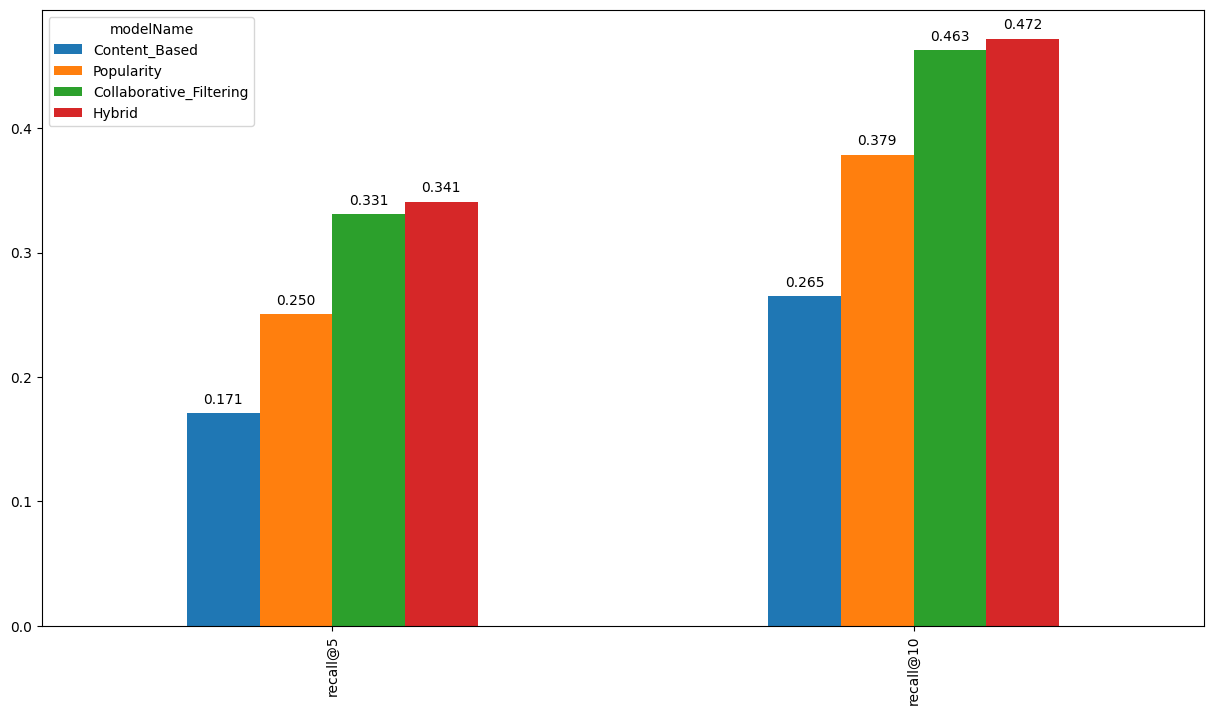

In [118]:
%matplotlib inline
axes = metrics_global_dataFrame.transpose().plot(kind='bar', figsize=(15, 8))
for p in axes.patches:
    #----------------------------------------------------------------
    axes.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')


# Testing


Let's test the best model (Hybrid) for my user.


In [119]:
def inspect_interactions(id_of_person, testing_set=True):
    if testing_set:
        data_frame_interactions = test_indexed_dataFrame_interactions
    else:
        data_frame_interactions = train_indexed_dataFrame_interactions
    return data_frame_interactions.loc[id_of_person].merge(Data_frame_articles, how='left',
                                                        left_on='contentId',
                                                        right_on='contentId') \
        .sort_values('event_Strength', ascending=False)[['event_Strength',
                                                         'contentId',
                                                         'title', 'url', 'lang']]


In [120]:
inspect_interactions(-1468311624256856883, testing_set=False).head(20)


,event_Strength,contentId,title,url,lang
87,4.285402,6342606568346442862,"At eBay, Machine Learning is Driving Innovativ...",https://www.ebayinc.com/stories/news/at-ebay-m...,en
51,4.129283,621816023386605502,AI Is Here to Help You Write Emails People Wil...,http://www.wired.com/2016/08/boomerang-using-a...,en
79,4.044394,-4460364688263064356,"Deep Learning for Chatbots, Part 1 - Introduction",http://www.wildml.com/2016/04/deep-learning-fo...,en
58,3.906891,2588533162305406436,6 reasons why I like KeystoneML,http://radar.oreilly.com/2015/06/6-reasons-why...,en
103,3.700440,-388680385666545248,10 Stats About Artificial Intelligence That Wi...,http://www.fool.com/investing/2016/06/18/10-st...,en
82,3.700440,5258604888412581248,Machine Learning Is No Longer Just for Experts,https://hbr.org/2016/10/machine-learning-is-no...,en
111,3.643856,-6466608104863161151,5 reasons your employees aren't sharing their ...,http://justcuriousblog.com/2016/04/5-reasons-y...,en
77,3.459432,-8366626164558006882,Bad Writing Is Destroying Your Company's Produ...,https://hbr.org/2016/08/bad-writing-is-destroy...,en
29,3.459432,444368485316508238,How to choose algorithms for Microsoft Azure M...,https://azure.microsoft.com/en-us/documentatio...,en
13,3.459432,-532888568436826210,IBM Seeks to Simplify Graph with New Titan Ser...,https://www.datanami.com/2016/06/26/ibm-seeks-...,en


In [121]:
hybrid_model.items_recommend(
    -1468311624256856883, top_n=20, verbose=True)


,recStrengthHybrid,contentId,title,url,lang
0,31.197553,-1801642485252324828,Designing smart notifications,https://medium.com/@intercom/designing-smart-n...,en
1,30.165622,-6626356661668886461,This Super Accurate Portrait Selection Tech Us...,http://petapixel.com/2016/06/28/super-accurate...,en
2,30.138294,-8033211546111606164,Google's Cloud Machine Learning service is now...,https://techcrunch.com/2016/08/28/googles-clou...,en
3,30.116683,4118643388464105405,Why Google App Engine rocks: A Google engineer...,https://cloudplatform.googleblog.com/2016/04/w...,en
4,30.016466,5258604888412581248,Machine Learning Is No Longer Just for Experts,https://hbr.org/2016/10/machine-learning-is-no...,en
5,29.716570,2588533162305406436,6 reasons why I like KeystoneML,http://radar.oreilly.com/2015/06/6-reasons-why...,en
6,29.458287,621816023386605502,AI Is Here to Help You Write Emails People Wil...,http://www.wired.com/2016/08/boomerang-using-a...,en
7,29.414954,-5154385666416065060,Innovation is in all the wrong places,https://techcrunch.com/2016/08/28/innovation-i...,en
8,29.393702,1005651836888864351,Seria Stranger Things uma obra de arte do algo...,https://www.linkedin.com/pulse/seria-stranger-...,pt
9,29.259158,4241385836165861843,Understanding the Twitter topic Tracker,https://unionmetrics.zendesk.com/hc/en-us/arti...,en
